In [1]:
import sys
sys.path.append('../ml_utils')

import config as cfg
import data_utils as du

import timeit
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pandas import read_csv
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
log_data = './../shared/data/swissid_authorize_logs_april_to_sept_2019.csv'

start = timeit.default_timer()
df = pd.read_csv(filepath_or_buffer=log_data, header=0, sep='\t', names=cfg.complete_feature_list, index_col=None)
stop = timeit.default_timer()

print("Original data frame size: {}\n".format(df.shape))
print("Time: {} seconds\n".format(stop - start))

Original data frame size: (12417597, 31)

Time: 52.599039464 seconds



In [3]:
# clean the dataframe
df = du.clean_data(df)

columns with NaN: loc_country_code
loc_country_code is fixed


In [4]:
# show all columns having NaN => if empty, that's perfect!
col_found = df.columns[df.isna().any()].tolist()
assert len(col_found) == 0, "found columns with NaN"

In [5]:
# feature selection
def select_features(X_train, y_train, X_test, func=chi2, top='all'):
    fs = SelectKBest(score_func=func, k=top)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [6]:
def score_barplot(feature_score):
    # what are scores for the features
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))

    # plot the scores
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()

In [7]:
def score_sort(features, scores):
    return sorted(list(zip(features,scores)), key=lambda t: t[1], reverse=True)

In [8]:
def print_counts(axis, rotation=45, inverse=False):
    
    if inverse:
        # set individual bar lables using above list
        for i in axis.patches:
            # get_width pulls left or right; get_y pushes up or down
            axis.text(i.get_width()+.1, i.get_y()+.31, \
                    str(round((i.get_width()), 2)), fontsize=15, color='dimgrey')
    else:
        if rotation <= 0:
            # set individual bar lables using above list        
            for i in axis.patches:
                # get_x pulls left or right; get_height pushes up or down
                axis.text(i.get_x()-.03, i.get_height()+.5, \
                        str(round(i.get_height(), 2)), fontsize=12, color='dimgrey')
        else:
            for i in axis.patches:
                # get_x pulls left or right; get_height pushes up or down
                axis.text(i.get_x()+.04, i.get_height()+12000, \
                        str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                            rotation=rotation)

In [9]:
def plot_bar(df, width, height, title='', counts=True, use_log=False, top=None):
    
    data = df['Score']
    
    if top:
        data = data[:top]
    
    if use_log:
        data = data.apply(lambda x : np.log(x))
        
    ax = data.plot(kind='barh', figsize=(width,height), fontsize=17)
        
    ax.set_alpha(0.8)
    ax.set_title(title, fontsize=15, fontweight="bold")
    ax.set_yticklabels(df['Feature'].values, fontsize=13)
        
    if counts:
        print_counts(ax, 0, True)
        
    ax.invert_yaxis()

In [10]:
def extract_top_k_features(features, scores, k=None):
    scores_list = list(zip(features,scores))
    sorted_scores = sorted(scores_list, key=lambda t: t[1], reverse=True)
    feature_ranking = list(map(lambda t: t[0], sorted_scores))
    
    if k:
        return feature_ranking[:k]
    else:
        return feature_ranking

In [11]:
def build_ranking_list(features, rfe_fit):
    scores_list = list(zip(features,rfe_fit.ranking_))
    sorted_scores = sorted(scores_list, key=lambda t: t[1], reverse=False)
    feature_ranking = list(map(lambda t: t[0], sorted_scores))
    top_k = features[rfe_fit.support_].tolist()
    k = rfe_fit.n_features_
    return k, top_k, feature_ranking

In [12]:
excludes=['label', 'ido_id']
excludes = list(set(excludes + cfg.unused_feature_list.copy()))
excludes.remove('loc_country_code')
excludes.remove('src_software_sub_type')
excludes.remove('src_hardware_sub_type')
excludes.remove('response_status_code')
excludes.remove('response_time_ms')
excludes.remove('loc_region')
excludes.remove('loc_city')

In [13]:
X, y, X_cols = du.build_normal_anomaly_feature_selection_sample_df(df, 70000, True, True, True, excludes)

In [14]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (46900, 22) (46900,)
Test (23100, 22) (23100,)


# Model evaluation with all features

In [15]:
# evaluation of a model using all input features

# fit the model
model = LogisticRegression(solver='lbfgs', max_iter=1000)
#model = LogisticRegression(solver='saga', max_iter=1000)

model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
baseline_accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (baseline_accuracy*100))

Accuracy: 82.49


In [16]:
def round_accuracy(value):
    
    base = 100*value
    acc = round(2*base)/2
    
    if acc > base:
        acc -= 0.5
    
    return acc / 100

In [17]:
def calc_top_k_features(k, method=chi2):
    
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, method, k)

    # fit the model
    model = LogisticRegression(solver='lbfgs', max_iter=1000)

    model.fit(X_train_fs, y_train)

    # evaluate the model
    yhat = model.predict(X_test_fs)

    # evaluate predictions
    accuracy = accuracy_score(y_test, yhat)
    print('k=' + str(k) + ', Accuracy=%.3f' % (accuracy*100))
    
    return accuracy, fs

In [18]:
def find_top_k_features(baseline_accuracy, features, method=chi2):
    
    k = 1
    accuracy = 0.0
    num_of_features = len(features)
    baseline_lower_limit = round_accuracy(baseline_accuracy)
    
    print("number of features=" + str(num_of_features) + ", baseline=" + str(100*baseline_accuracy) 
          + ", limit=" + str(100*baseline_lower_limit))
    
    while accuracy < baseline_lower_limit and k <= num_of_features:
        accuracy, fs = calc_top_k_features(k, method)
        k+=1
        
    top_k_featrues = extract_top_k_features(features, fs.scores_, k-1)
    return (k-1,accuracy,top_k_featrues), fs
        

In [19]:
def calc_top_k_features_rfe(k):
    
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    rfe = RFE(model, k)
    fit = rfe.fit(X_train, y_train)

    #print("Num Features: %d" % fit.n_features_)
    #print("Selected Features: %s" % fit.support_)
    #print("Feature Ranking: %s" % fit.ranking_)

    # evaluate the model
    yhat = fit.predict(X_test)

    # evaluate predictions
    accuracy = accuracy_score(y_test, yhat)
    print('k=' + str(k) + ', Accuracy=%.3f' % (accuracy*100))
    
    return accuracy, fit

In [20]:
def find_top_k_features_rfe(baseline_accuracy, features):
    
    k = 1
    accuracy = 0.0
    num_of_features = len(features)
    baseline_lower_limit = round_accuracy(baseline_accuracy)
    
    print("number of features=" + str(num_of_features) + ", baseline=" + str(100*baseline_accuracy) 
          + ", limit=" + str(100*baseline_lower_limit))
    
    while accuracy < baseline_lower_limit and k <= num_of_features:
        accuracy, fit= calc_top_k_features_rfe(k)
        k+=1
        
    rfe_k,top_k_featrues,feature_ranking = build_ranking_list(features, fit)
    
    return (rfe_k,accuracy,top_k_featrues), feature_ranking

In [21]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

# Model evaluation with top k features and Chi2

In [22]:
chi2_values, fs = find_top_k_features(baseline_accuracy, X_cols, chi2)

number of features=22, baseline=82.4935064935065, limit=82.0
k=1, Accuracy=75.511
k=2, Accuracy=75.944
k=3, Accuracy=77.251
k=4, Accuracy=82.463


Feature 0: 106.858439
Feature 1: 3.010441
Feature 2: 325.100531
Feature 3: 2819.346364
Feature 4: 453.689543
Feature 5: 1900.899841
Feature 6: 1180.237885
Feature 7: 1301.598515
Feature 8: 822.635283
Feature 9: 158.097880
Feature 10: 1839.343534
Feature 11: 20.260011
Feature 12: 19.970272
Feature 13: 5.473493
Feature 14: 244.609073
Feature 15: 9.154330
Feature 16: 162.475885
Feature 17: 523.232921
Feature 18: 43.530061
Feature 19: 576.052398
Feature 20: 1457.164690
Feature 21: 4812.669818


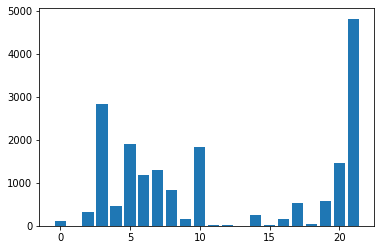

In [23]:
score_barplot(fs)

In [24]:
chi2_values

(4,
 0.8246320346320346,
 ['loc_country_code',
  'src_operating_system_name',
  'src_software_sub_type',
  'response_status_code'])

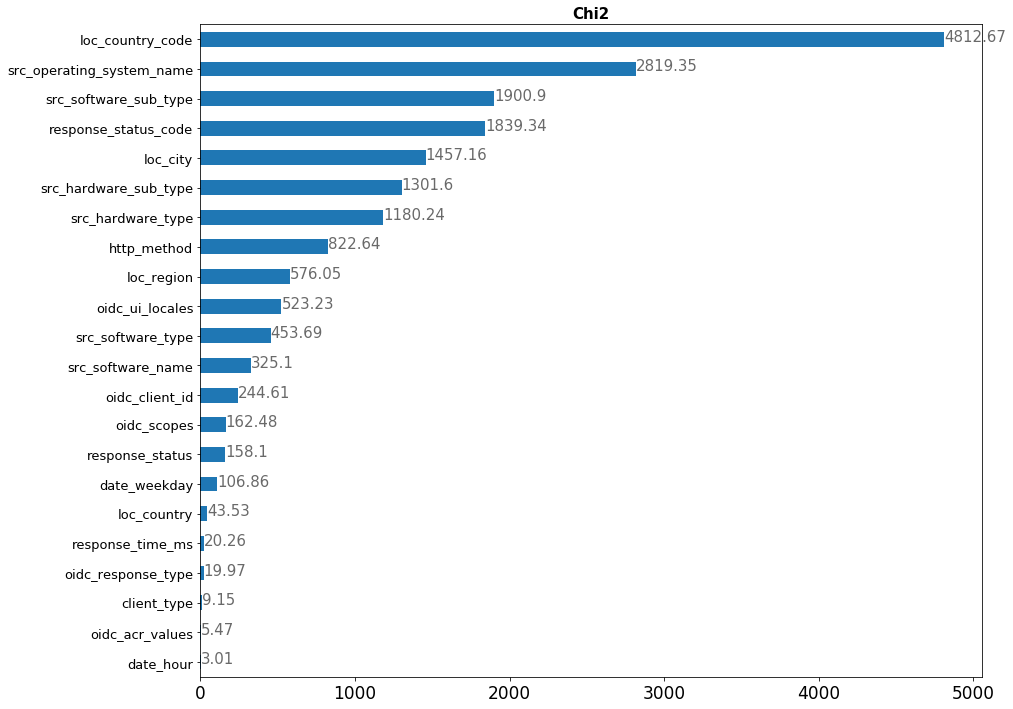

In [25]:
scores = score_sort(X_cols, fs.scores_)
score_df = pd.DataFrame.from_records(scores, columns =['Feature','Score'])
#score_df
plot_bar(score_df, 14, 12, 'Chi2', True)

In [26]:
accuracy, fs = calc_top_k_features(10, chi2)
chi2_top_k_featrues = extract_top_k_features(X_cols, fs.scores_, 10)
accuracy, chi2_top_k_featrues

k=10, Accuracy=82.446


(0.8244588744588744,
 ['loc_country_code',
  'src_operating_system_name',
  'src_software_sub_type',
  'response_status_code',
  'loc_city',
  'src_hardware_sub_type',
  'src_hardware_type',
  'http_method',
  'loc_region',
  'oidc_ui_locales'])

# Model evaluation with top k features and Mutual-Info

In [27]:
mic_values, fs = find_top_k_features(baseline_accuracy, X_cols, mutual_info_classif)

number of features=22, baseline=82.4935064935065, limit=82.0
k=1, Accuracy=72.342
k=2, Accuracy=78.684
k=3, Accuracy=79.567
k=4, Accuracy=79.394
k=5, Accuracy=79.861
k=6, Accuracy=79.714
k=7, Accuracy=80.381
k=8, Accuracy=79.606
k=9, Accuracy=80.481
k=10, Accuracy=80.424
k=11, Accuracy=80.442
k=12, Accuracy=80.455
k=13, Accuracy=82.416


Feature 0: 0.007113
Feature 1: 0.022784
Feature 2: 0.239470
Feature 3: 0.231729
Feature 4: 0.242287
Feature 5: 0.240092
Feature 6: 0.237457
Feature 7: 0.034393
Feature 8: 0.021553
Feature 9: 0.047349
Feature 10: 0.040757
Feature 11: 0.509858
Feature 12: 0.007300
Feature 13: 0.008566
Feature 14: 0.268619
Feature 15: 0.014680
Feature 16: 0.237497
Feature 17: 0.013785
Feature 18: 0.223021
Feature 19: 0.233453
Feature 20: 0.234560
Feature 21: 0.218724


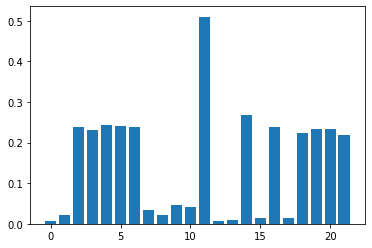

In [28]:
score_barplot(fs)

In [29]:
mic_values

(13,
 0.8241558441558442,
 ['response_time_ms',
  'oidc_client_id',
  'src_software_type',
  'src_software_sub_type',
  'src_software_name',
  'oidc_scopes',
  'src_hardware_type',
  'loc_city',
  'loc_region',
  'src_operating_system_name',
  'loc_country',
  'loc_country_code',
  'response_status'])

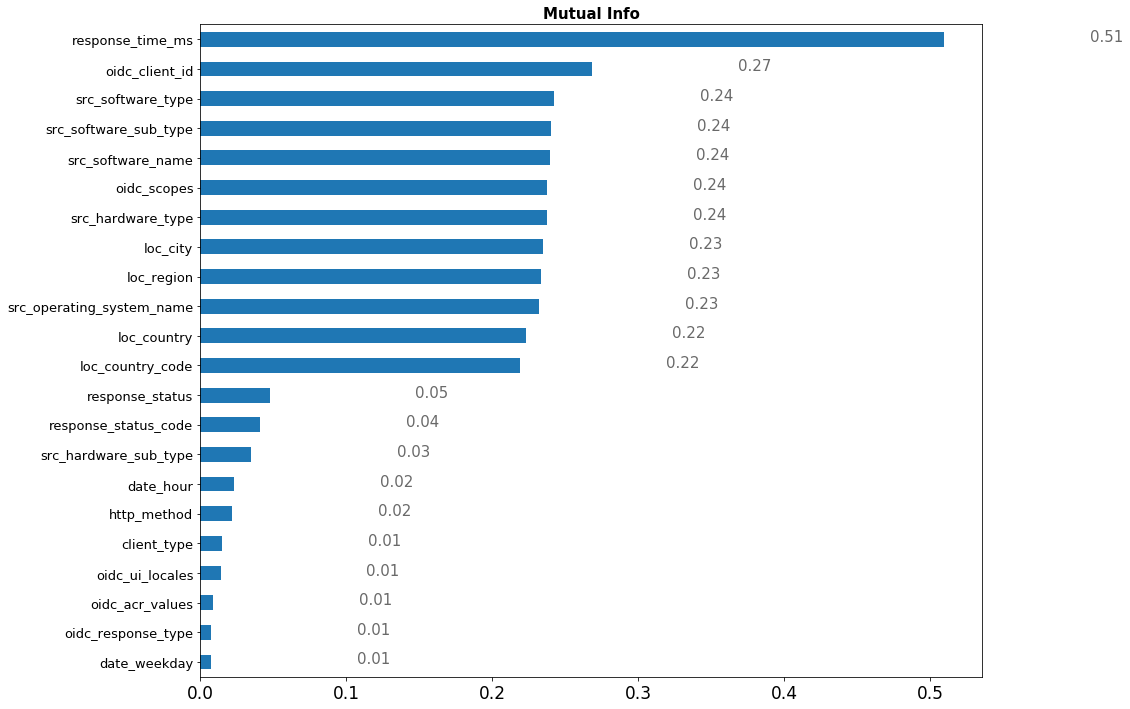

In [30]:
scores = score_sort(X_cols, fs.scores_)
score_df = pd.DataFrame.from_records(scores, columns =['Feature','Score'])
#score_df
plot_bar(score_df, 14, 12, 'Mutual Info', True)

In [31]:
accuracy, fs = calc_top_k_features(10, mutual_info_classif)
mic_top_k_featrues = extract_top_k_features(X_cols, fs.scores_, 10)
accuracy, mic_top_k_featrues

k=10, Accuracy=80.424


(0.8042424242424242,
 ['response_time_ms',
  'oidc_client_id',
  'src_software_name',
  'src_software_sub_type',
  'src_software_type',
  'src_hardware_type',
  'loc_city',
  'oidc_scopes',
  'loc_region',
  'src_operating_system_name'])

# Model evaluation with top k features and Recursive Feature Elimination (RFE)

In [32]:
rfe_values, rfe_ranking = find_top_k_features_rfe(baseline_accuracy, X_cols)

number of features=22, baseline=82.4935064935065, limit=82.0
k=1, Accuracy=77.528
k=2, Accuracy=77.394
k=3, Accuracy=82.515


In [33]:
rfe_ranking

['src_software_type',
 'src_software_sub_type',
 'response_status',
 'response_time_ms',
 'response_status_code',
 'http_method',
 'oidc_ui_locales',
 'oidc_client_id',
 'oidc_scopes',
 'loc_country_code',
 'src_hardware_type',
 'src_hardware_sub_type',
 'loc_country',
 'oidc_response_type',
 'src_software_name',
 'src_operating_system_name',
 'date_weekday',
 'loc_city',
 'loc_region',
 'client_type',
 'oidc_acr_values',
 'date_hour']

In [34]:
rfe_values

(3,
 0.8251515151515152,
 ['src_software_type', 'src_software_sub_type', 'response_status'])

In [35]:
accuracy, fit = calc_top_k_features_rfe(10)
rfe_k,rfe_top_k_featrues,feature_ranking = build_ranking_list(X_cols, fit)
accuracy, rfe_top_k_featrues

k=10, Accuracy=82.498


(0.824978354978355,
 ['src_software_type',
  'src_software_sub_type',
  'http_method',
  'response_status',
  'response_status_code',
  'response_time_ms',
  'oidc_client_id',
  'oidc_scopes',
  'oidc_ui_locales',
  'loc_country_code'])

# Common features

In [36]:
chi2_mic_features = intersection(chi2_values[2], mic_values[2])
chi2_mic_features

['loc_country_code', 'src_software_sub_type', 'src_operating_system_name']

In [37]:
chi2_rfe_features = intersection(chi2_values[2], rfe_values[2])
chi2_rfe_features

['src_software_sub_type']

In [38]:
mic_rfe_features = intersection(mic_values[2], rfe_values[2])
mic_rfe_features

['src_software_type', 'response_status', 'src_software_sub_type']

In [39]:
common_selected_features = intersection(chi2_mic_features, rfe_values[2])
common_selected_features

['src_software_sub_type']

# Common top 10 features

In [40]:
chi2_mic_features = intersection(chi2_top_k_featrues, mic_top_k_featrues)
chi2_mic_features

['src_operating_system_name',
 'loc_city',
 'loc_region',
 'src_hardware_type',
 'src_software_sub_type']

In [41]:
chi2_rfe_features = intersection(chi2_top_k_featrues, rfe_top_k_featrues)
chi2_rfe_features

['http_method',
 'oidc_ui_locales',
 'response_status_code',
 'loc_country_code',
 'src_software_sub_type']

In [42]:
mic_rfe_features = intersection(mic_top_k_featrues, rfe_top_k_featrues)
mic_rfe_features

['src_software_type',
 'oidc_scopes',
 'response_time_ms',
 'src_software_sub_type',
 'oidc_client_id']

In [43]:
common_selected_features = intersection(chi2_mic_features, rfe_top_k_featrues)
common_selected_features

['src_software_sub_type']

## Used Feature List

In [44]:
X_cols.tolist()

['date_weekday',
 'date_hour',
 'src_software_name',
 'src_operating_system_name',
 'src_software_type',
 'src_software_sub_type',
 'src_hardware_type',
 'src_hardware_sub_type',
 'http_method',
 'response_status',
 'response_status_code',
 'response_time_ms',
 'oidc_response_type',
 'oidc_acr_values',
 'oidc_client_id',
 'client_type',
 'oidc_scopes',
 'oidc_ui_locales',
 'loc_country',
 'loc_region',
 'loc_city',
 'loc_country_code']